# Dataset Distillation on MNIST Dataset
--- 
Ulus Emir Aslan - 150210320

Kaan Yücel - 150210318

Furkan Ataç - 150210304

---

# 1st Part

### Importing MNIST

In [1]:
from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from keras.datasets import mnist

# Load the MNIST dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Preprocess the data
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1).astype('float32') / 255
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1).astype('float32') / 255

# One-hot encode the labels
train_y = to_categorical(train_y, 10)
test_y = to_categorical(test_y, 10)

# Define the CNN model
def create_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create and train the model
model = create_model()
model.fit(train_X, train_y, epochs=10, batch_size=128, validation_data=(test_X, test_y))

# Evaluate the model
score = model.evaluate(test_X, test_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Epoch 1/10
469/469 [==============================] - 11s 24ms/step - loss: 0.2037 - accuracy: 0.9411 - val_loss: 0.0561 - val_accuracy: 0.9836
Epoch 2/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0561 - accuracy: 0.9832 - val_loss: 0.0435 - val_accuracy: 0.9858
Epoch 3/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0385 - accuracy: 0.9882 - val_loss: 0.0309 - val_accuracy: 0.9886
Epoch 4/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0293 - accuracy: 0.9907 - val_loss: 0.0331 - val_accuracy: 0.9887
Epoch 5/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0232 - accuracy: 0.9925 - val_loss: 0.0305 - val_accuracy: 0.9903
Epoch 6/10
469/469 [==============================] - 11s 24ms/step - loss: 0.0180 - accuracy: 0.9943 - val_loss: 0.0272 - val_accuracy: 0.9907
Epoch 7/10
469/469 [==============================] - 12s 25ms/step - loss: 0.0141 - accuracy: 0.9952 - val_loss: 0.0345 - val_accuracy:

### Parameter Matching

In [4]:
import numpy as np
from tensorflow.keras.optimizers import Adam

num_synthetic_images = 100  # Number of synthetic images
synthetic_X = np.random.randn(num_synthetic_images, 28, 28, 1).astype('float32')
synthetic_y = np.random.randint(0, 10, num_synthetic_images)
synthetic_y = to_categorical(synthetic_y, 10)

# Convert synthetic_X to a TensorFlow variable
synthetic_X_var = tf.Variable(synthetic_X, dtype=tf.float32)
synthetic_model = create_model() # and build it

# parameter matching loss function
def parameter_matching_loss(synthetic_model, real_model, synthetic_X):
    synthetic_model.set_weights(real_model.get_weights())
    predictions = synthetic_model(synthetic_X)
    loss = tf.keras.losses.categorical_crossentropy(synthetic_y, predictions)
    return tf.reduce_mean(loss)

optimizer = Adam()


for step in range(1, 1001):  # Number of optimization steps
    with tf.GradientTape() as tape:
        tape.watch(synthetic_X_var)
        loss = parameter_matching_loss(synthetic_model, model, synthetic_X_var)
    grads = tape.gradient(loss, [synthetic_X_var])
    
    if grads[0] is None:
        print(f"No gradients found at step {step}. Skipping this step.")
        continue

    optimizer.apply_gradients(zip(grads, [synthetic_X_var]))
    
    if step % 100 == 0:
        print(f"Optimization step {step} completed with loss: {loss.numpy()}")

# Train the synthetic model on the optimized synthetic dataset
synthetic_X_optimized = synthetic_X_var.numpy()
synthetic_model.fit(synthetic_X_optimized, synthetic_y, epochs=10, batch_size=20)

# Evaluate the synthetic model
synthetic_score = synthetic_model.evaluate(test_X, test_y, verbose=0)
print('Test loss:', synthetic_score[0])
print('Test accuracy:', synthetic_score[1])


Optimization step 0 completed with loss: 9.534409523010254
Optimization step 100 completed with loss: 1.2887132167816162
Optimization step 200 completed with loss: 0.1066955029964447
Optimization step 300 completed with loss: 0.029874620959162712
Optimization step 400 completed with loss: 0.01664005219936371
Optimization step 500 completed with loss: 0.011109360493719578
Optimization step 600 completed with loss: 0.00805054884403944
Optimization step 700 completed with loss: 0.006177314557135105
Optimization step 800 completed with loss: 0.00492840213701129
Optimization step 900 completed with loss: 0.004033780191093683
Epoch 1/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0034 - accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 5ms/step - loss: 8.1243e-04 - accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 1.5892e-04 - accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 6ms/step - loss: 1.9225

# 2nd Part

In [ ]:
!pip install imblearn

In [ ]:
import numpy as np
import pandas as pd
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

(train_x, train_y) ,(test_x, test_y) = mnist.load_data()
print(train_x.shape)

# Normalize and reshape the data
train_x = train_x.reshape(-1, 28*28).astype(np.float32) / 255.0
test_x = test_x.reshape(-1, 28*28).astype(np.float32) / 255.0

(60000, 28, 28)


In [ ]:
# These classifiers will be used with different hyperparameters

svm_kernels = ['linear', 'poly', 'rbf'] # Different kernels
decision_tree_criteria = ['gini', 'entropy']  # Criteria for splitting
random_forest_n_estimators = [50, 100, 200] # Number of trees in the forest

In [ ]:
# Training SVM, Decision Tree and Random Forest classifiers with different hyperparameters
svm_classifiers = {f'SVM_{kernel}': SVC(kernel=kernel, random_state=42) for kernel in svm_kernels}
decision_tree_classifiers = {f'DT_{criterion}': DecisionTreeClassifier(criterion=criterion, random_state=42) for criterion in decision_tree_criteria}
random_forest_classifiers = {f'RF_{n}': RandomForestClassifier(n_estimators=n, random_state=42) for n in random_forest_n_estimators}

In [ ]:
# Combine all classifiers
classifiers = {**svm_classifiers, **decision_tree_classifiers, **random_forest_classifiers}

# Fit the classifiers and evaluate their performance
# A dictionary to keep track of the performance of the model trained with the original data
performance_metrics = {}
for name, clf in classifiers.items():
    clf.fit(train_x, train_y)
    y_pred = clf.predict(test_x)
    performance_metrics[name] = {
        'accuracy': accuracy_score(test_y, y_pred),
        'precision': precision_score(test_y, y_pred, average='macro'),
        'recall': recall_score(test_y, y_pred, average='macro'),
        'f1_score': f1_score(test_y, y_pred, average='macro')
    }

# The performance of the models (accuracy, precision, recall, f1_score)
performance_metrics_df = pd.DataFrame(performance_metrics).T
print(performance_metrics_df)

            accuracy  precision    recall  f1_score
SVM_linear    0.9404   0.939918  0.939422  0.939514
SVM_poly      0.9771   0.977115  0.976938  0.977004
SVM_rbf       0.9792   0.979197  0.979092  0.979130
DT_gini       0.8754   0.874046  0.873825  0.873879
DT_entropy    0.8857   0.884202  0.884204  0.884174
RF_50         0.9668   0.966682  0.966568  0.966591
RF_100        0.9704   0.970268  0.970110  0.970163
RF_200        0.9707   0.970527  0.970432  0.970464


In [ ]:
# A dictionary to keep track of the performance of the model trained with distilled data
distilled_metrics = {}


# Dimensionality Reduction using PCA, the dimension of data will be transformed into 20 from 784
pca = PCA(n_components=20)
train_x_pca = pca.fit_transform(train_x)
test_x_pca = pca.transform(test_x)

# Training the model with the distilled data (dimension reduction)
for name, clf in classifiers.items():
    clf.fit(train_x_pca, train_y)
    y_pred = clf.predict(test_x_pca)
    distilled_metrics[f'{name}_PCA'] = {
        'accuracy': accuracy_score(test_y, y_pred),
        'precision': precision_score(test_y, y_pred, average='macro'),
        'recall': recall_score(test_y, y_pred, average='macro'),
        'f1_score': f1_score(test_y, y_pred, average='macro')
    }

In [ ]:
# Prototype Selection using KMeans
def prototype_selection(X, y, num_prototypes):
    """
    Parameters:
    - X: The input data to find prototypes
    - y: The target labels corresponding to X
    - num_prototypes: The number of prototypes to select

    Returns:
    - prototype_X: The selected prototype data points
    - prototype_y: The labels corresponding to the selected prototype data points
    """
    kmeans = KMeans(n_clusters=num_prototypes, random_state=42, n_init=10)
    kmeans.fit(X)
    cluster_centers = kmeans.cluster_centers_
    
    # Find the closest data points to the cluster centers
    closest_indices = []
    for center in cluster_centers:
        distances = np.linalg.norm(X - center, axis=1)
        closest_index = np.argmin(distances)
        closest_indices.append(closest_index)
    
    return X[closest_indices], y[closest_indices]

# Number of prototypes to select
num_prototypes = 1000
train_x_prototypes, train_y_prototypes = prototype_selection(train_x_pca, train_y, num_prototypes)

# Training the model with the distilled data (prototype selection dimension reduction together)
for name, clf in classifiers.items():
    clf.fit(train_x_prototypes, train_y_prototypes)
    y_pred = clf.predict(test_x_pca)
    distilled_metrics[f'{name}_Prototypes'] = {
        'accuracy': accuracy_score(test_y, y_pred),
        'precision': precision_score(test_y, y_pred, average='macro'),
        'recall': recall_score(test_y, y_pred, average='macro'),
        'f1_score': f1_score(test_y, y_pred, average='macro')
    }

In [ ]:
# The accuracy values of the models trained with distilled data
for classifier, metrics in distilled_metrics.items():
    for metric, point in metrics.items():
        if metric == 'accuracy':
            print(classifier,' ', metric, ' ', point)

SVM_linear_PCA   accuracy   0.9107
SVM_poly_PCA   accuracy   0.9734
SVM_rbf_PCA   accuracy   0.9752
DT_gini_PCA   accuracy   0.8476
DT_entropy_PCA   accuracy   0.8592
RF_50_PCA   accuracy   0.9472
RF_100_PCA   accuracy   0.9488
RF_200_PCA   accuracy   0.949
SVM_linear_Prototypes   accuracy   0.8758
SVM_poly_Prototypes   accuracy   0.9228
SVM_rbf_Prototypes   accuracy   0.9375
DT_gini_Prototypes   accuracy   0.7221
DT_entropy_Prototypes   accuracy   0.6969
RF_50_Prototypes   accuracy   0.8731
RF_100_Prototypes   accuracy   0.8802
RF_200_Prototypes   accuracy   0.8859


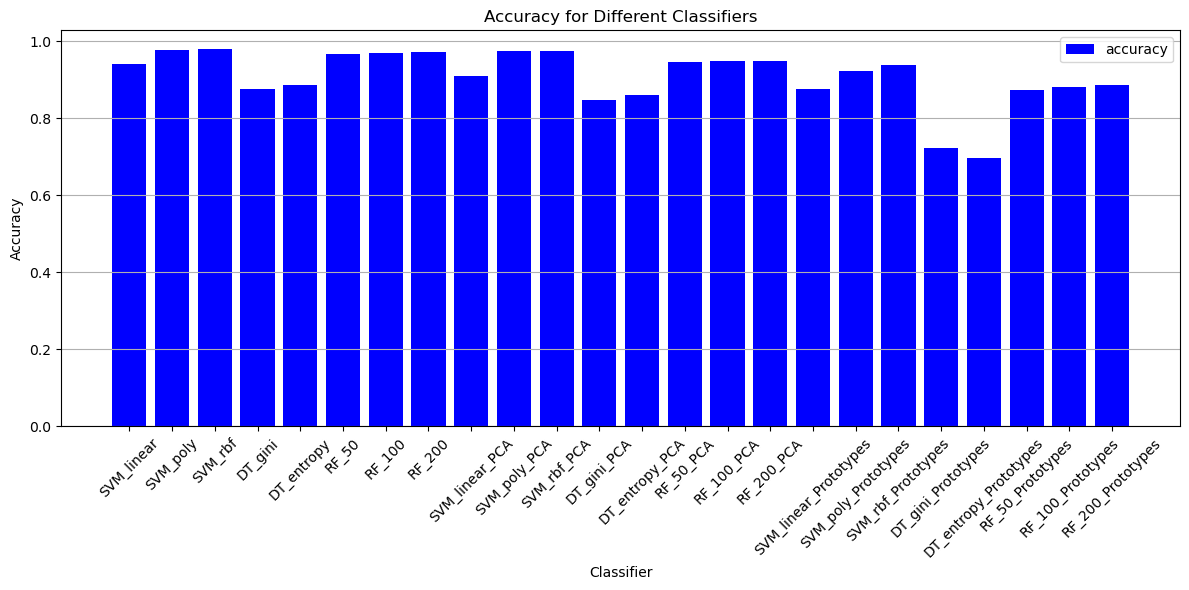

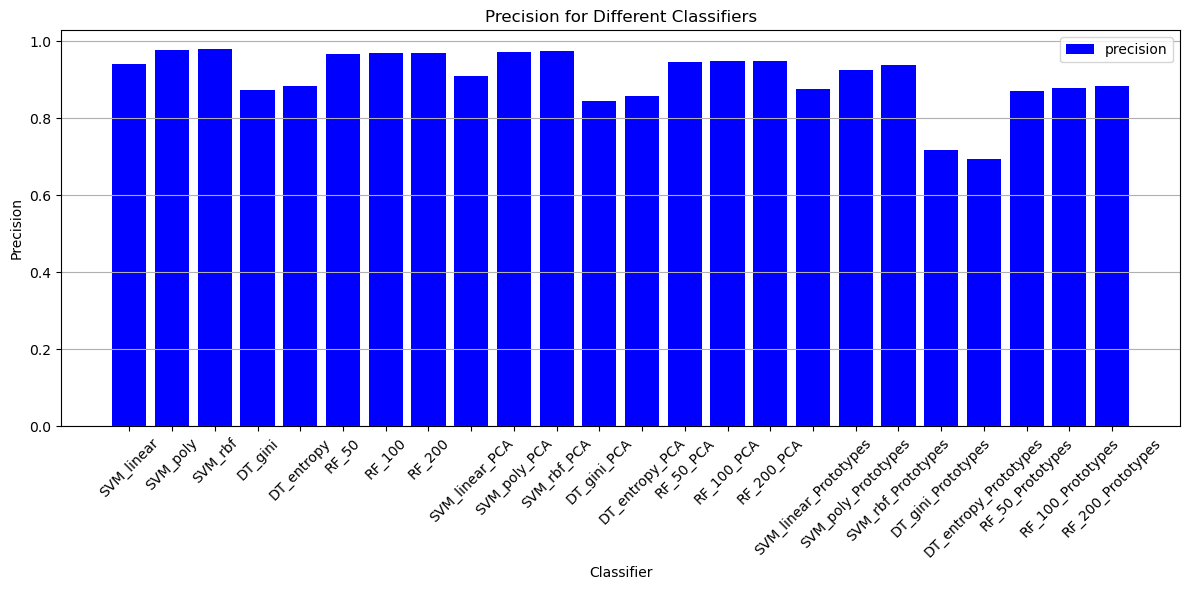

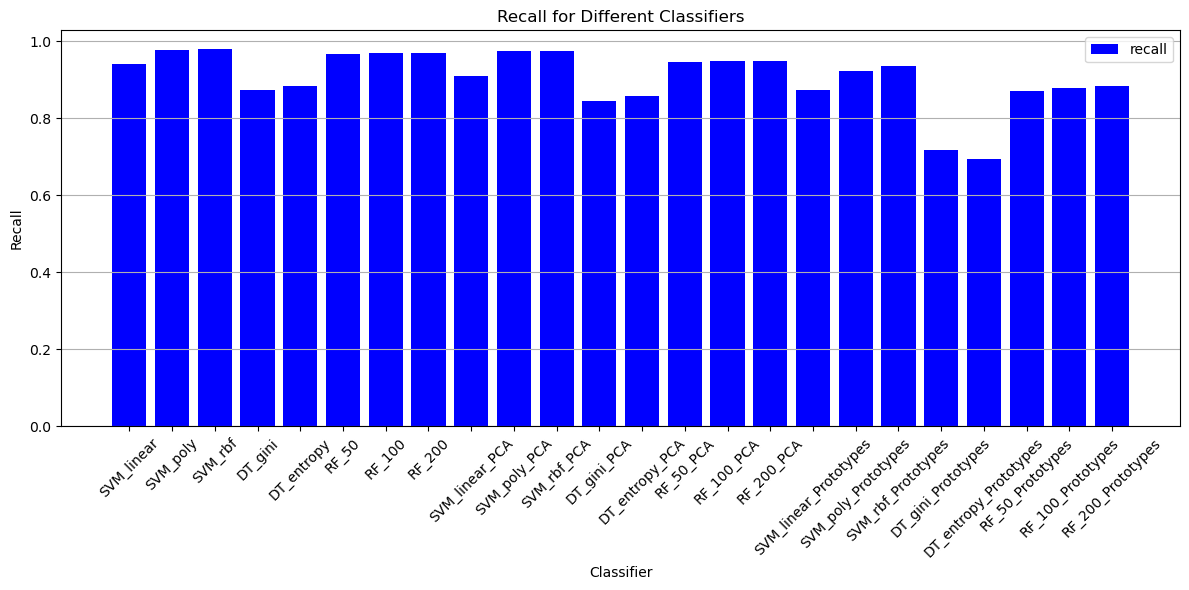

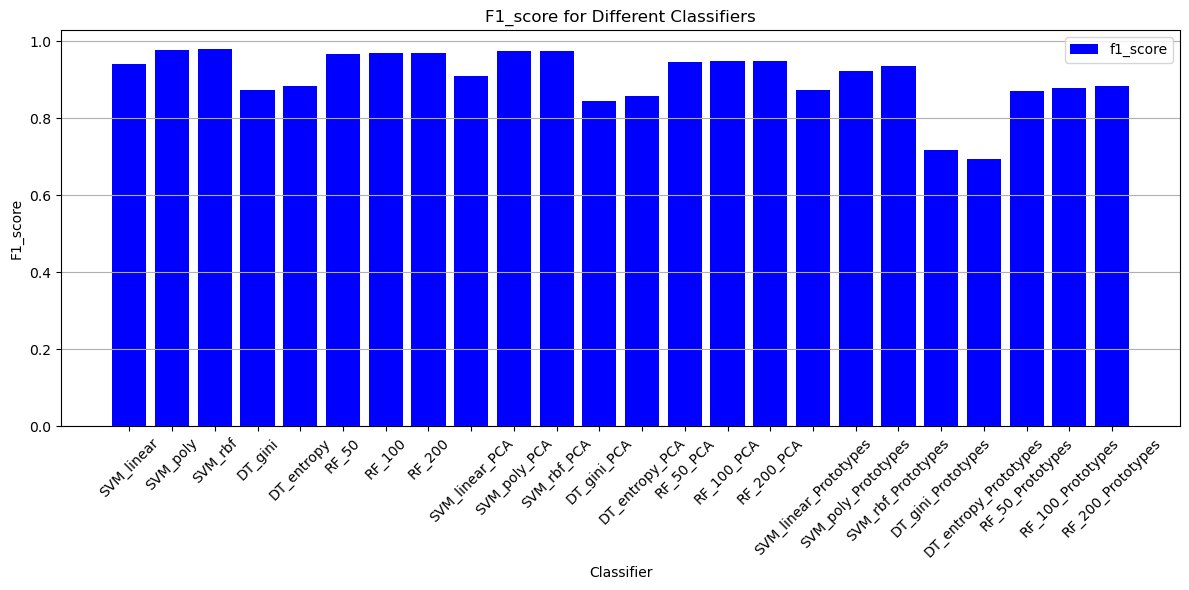

In [ ]:
# Comparing the performances for performance matching with plots

# Gathering all of the models and metrics
all_metrics = {**performance_metrics, **distilled_metrics}
all_metrics_df = pd.DataFrame(all_metrics).T

# Function to plot the metrics
def plot_metric(metric_name, df):
    plt.figure(figsize=(12, 6))
    classifiers = df.index
    values = df[metric_name]
    plt.bar(classifiers, values, color='b', label=metric_name)
    plt.title(f'{metric_name.capitalize()} for Different Classifiers')
    plt.xlabel('Classifier')
    plt.ylabel(metric_name.capitalize())
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()


metrics = ['accuracy', 'precision', 'recall', 'f1_score']
for metric in metrics:
    plot_metric(metric, all_metrics_df)

plt.show()

# 3rd Part

In [ ]:
# Load the MNIST dataset and print the shapes of the training and test sets

from keras.datasets import mnist

(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))



X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


In [ ]:
# Reshape and normalize the MNIST dataset

train_X = train_X.reshape(train_X.shape[0], -1)
test_X = test_X.reshape(test_X.shape[0], -1)

# Normalize the pixel values to be between 0 and 1 (optional)
train_X = train_X.astype('float32') / 255.0
test_X = test_X.astype('float32') / 255.0

In [ ]:
# Import necessary libraries for data manipulation, model training, and evaluation

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import wasserstein_distance
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def evaluate_model(model, test_X, test_y):
    """Evaluate a trained model using accuracy, precision, recall, and F1 score."""
    predictions = model.predict(test_X)
    accuracy = accuracy_score(test_y, predictions)
    precision = precision_score(test_y, predictions, average='weighted')
    recall = recall_score(test_y, predictions, average='weighted')
    f1 = f1_score(test_y, predictions, average='weighted')
    return accuracy, precision, recall, f1

def train_naive_bayes(train_X, train_y, test_X, test_y):
    """Train a Naive Bayes model and evaluate its performance."""
    model = GaussianNB()
    model.fit(train_X, train_y)
    return evaluate_model(model, test_X, test_y)

def train_logistic_regression(train_X, train_y, test_X, test_y, max_iter=1000, solver='lbfgs'):
    """Train a Logistic Regression model and evaluate its performance."""
    model = LogisticRegression(max_iter=max_iter, solver=solver)
    model.fit(train_X, train_y)
    return evaluate_model(model, test_X, test_y)

def train_knn(train_X, train_y, test_X, test_y, n_neighbors=3):
    """Train a K-Nearest Neighbors model and evaluate its performance."""
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(train_X, train_y)
    return evaluate_model(model, test_X, test_y)

In [ ]:
knn_metrics = train_knn(train_X, train_y, test_X, test_y, n_neighbors=5)

In [ ]:
nb_metrics = train_naive_bayes(train_X, train_y, test_X, test_y)

In [ ]:
lr_metrics = train_logistic_regression(train_X, train_y, test_X, test_y, max_iter=200)

C:\Users\Kaan\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from tabulate import tabulate

# Define the metrics for each model
models_metrics = [
    ("Naive Bayes", nb_metrics),
    ("Logistic Regression", lr_metrics),
    ("K Nearest Neighbors", knn_metrics)
]

# Prepare the data for tabulation
table_data = []
for model, metrics in models_metrics:
    table_data.append([model, *metrics])

# Print the table
print(tabulate(table_data, headers=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]))


Model                   Accuracy    Precision    Recall    F1 Score
--------------------  ----------  -----------  --------  ----------
Naive Bayes               0.5558     0.691726    0.5558    0.517042
Logistic Regression       0.9269     0.926695    0.9269    0.926723
K Nearest Neighbours      0.9688     0.969021    0.9688    0.968747


In [ ]:
from sklearn.decomposition import TruncatedSVD

def apply_svd(train_X, test_X, n_components):
    """Apply Singular Value Decomposition (SVD) to reduce dimensionality of the data."""
    # Perform SVD on the training data
    U_train, s_train, Vt_train = np.linalg.svd(train_X, full_matrices=False)
    
    # Select the top n_components singular values and vectors
    U_train_reduced = U_train[:, :n_components]
    s_train_reduced = np.diag(s_train[:n_components])
    Vt_train_reduced = Vt_train[:n_components, :]
    
    # Reduce dimensions of the training data
    train_X_reduced = np.dot(U_train_reduced, np.dot(s_train_reduced, Vt_train_reduced))
    
    # Reduce dimensions of the test data using the same transformation learned from the training data
    U_test, s_test, Vt_test = np.linalg.svd(test_X, full_matrices=False)
    
    U_test_reduced = U_test[:, :n_components]
    s_test_reduced = np.diag(s_test[:n_components])
    Vt_test_reduced = Vt_test[:n_components, :]
    
    test_X_reduced = np.dot(U_test_reduced, np.dot(s_test_reduced, Vt_test_reduced))
    
    return train_X_reduced, test_X_reduced


In [ ]:
# Apply SVD to the dataset
n_components = 100  # Adjust the number of components as needed
train_X_reduced, test_X_reduced = apply_svd(train_X, test_X, n_components)



In [ ]:
# Create DataFrames for the original and SVD-reduced training data, rounding values to 2 decimal places
original_df = pd.DataFrame(train_X).round(2)
distilled_df = pd.DataFrame(train_X_reduced).round(2)

# Generate descriptive statistics for the original and reduced data
original_stats = original_df.describe()
distilled_stats = distilled_df.describe()


In [ ]:
print("Original train data statistics")
print(original_stats[[250,450,550]])
print("--------------------------------------------------------")
print("Distilled train data statistics")
print(distilled_stats[[250,450,550]])

Original train data statistics
                250           450           550
count  60000.000000  60000.000000  60000.000000
mean       0.001888      0.000291      0.361885
std        0.035007      0.013488      0.427459
min        0.000000      0.000000      0.000000
25%        0.000000      0.000000      0.000000
50%        0.000000      0.000000      0.030000
75%        0.000000      0.000000      0.900000
max        1.000000      1.000000      1.000000
--------------------------------------------------------
Distilled train data statistics
                250           450           550
count  60000.000000  60000.000000  60000.000000
mean       0.001679      0.000238      0.362167
std        0.008578      0.001459      0.414858
min       -0.031100     -0.007399     -0.376538
25%       -0.002897     -0.000569     -0.003434
50%        0.000567      0.000147      0.184496
75%        0.004391      0.000891      0.769125
max        0.074587      0.013696      1.273833


Histograms serve as a visual tool to evaluate the effectiveness of dimensionality reduction techniques in maintaining the statistical properties of the original data. They help in understanding whether the distilled data retains important information present in the original dataset's feature distributions.

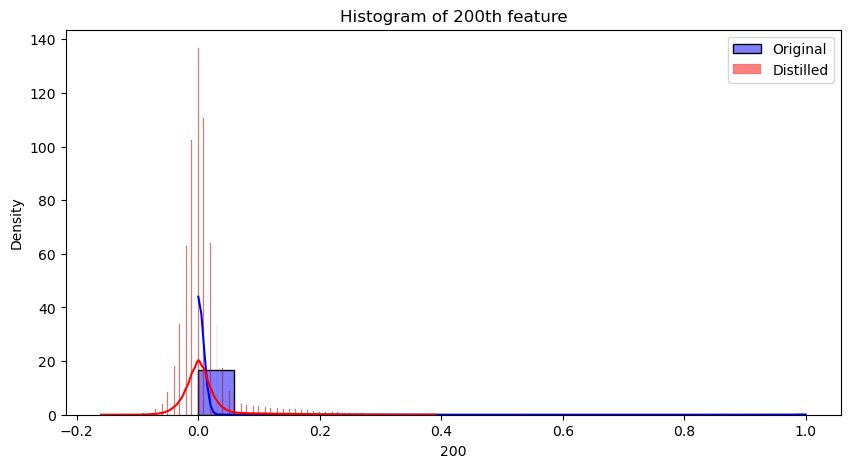

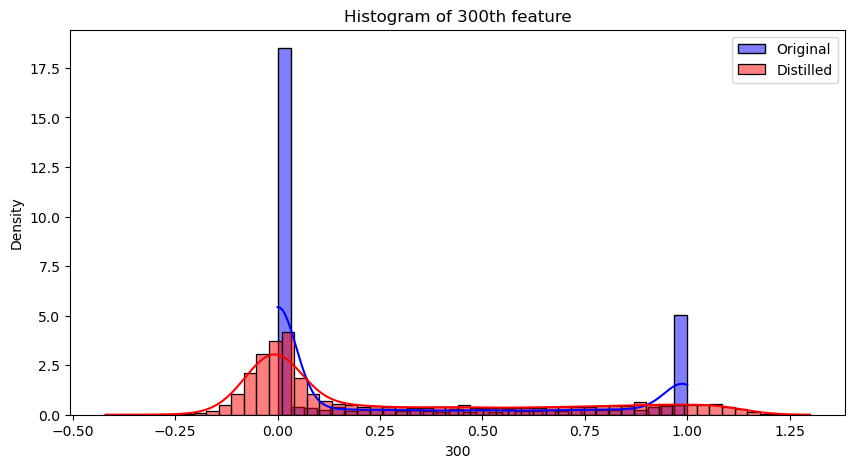

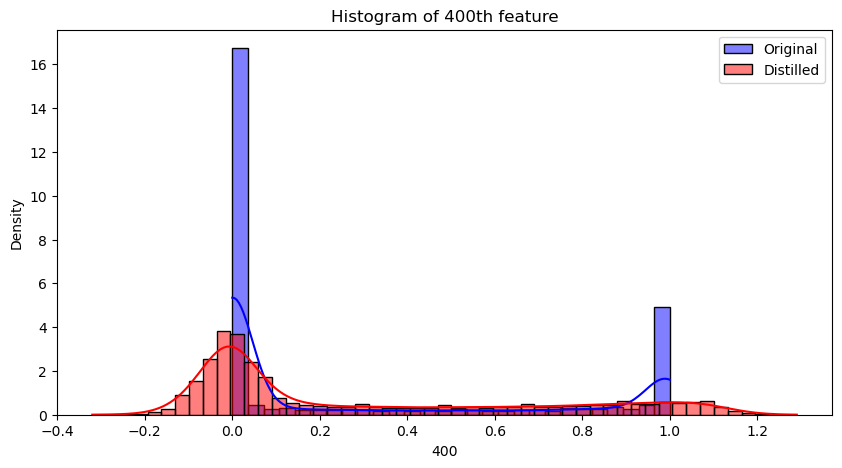

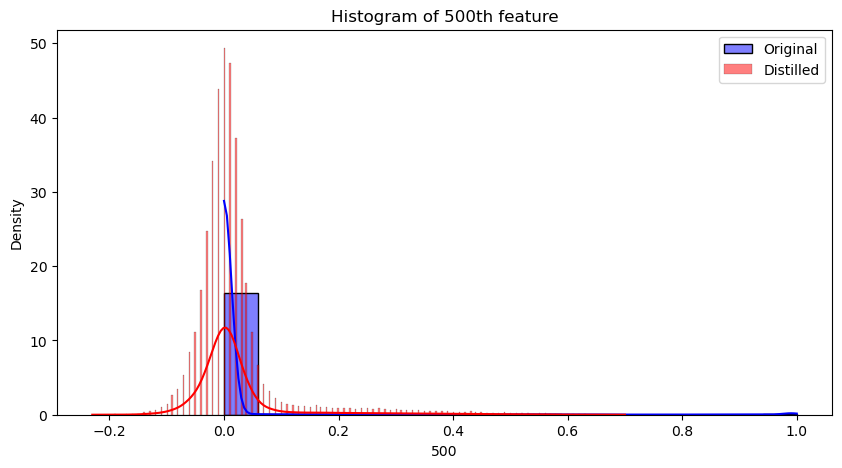

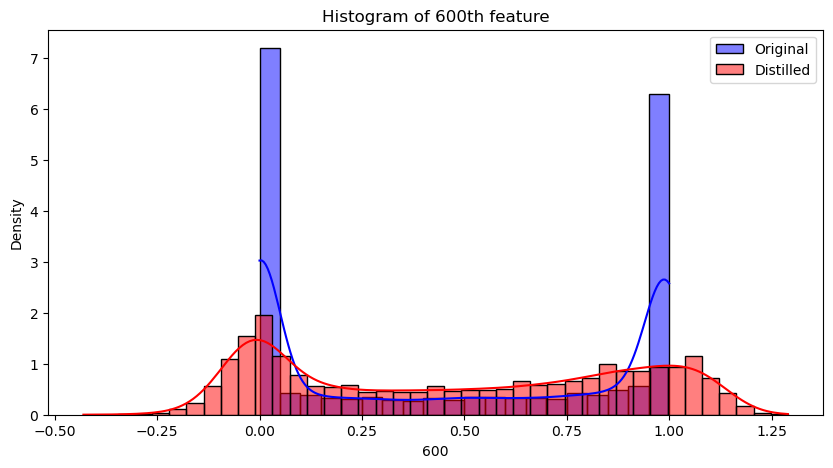

In [ ]:
for column in [200, 300, 400, 500, 600]:
    # Create a figure and set its size
    plt.figure(figsize=(10, 5))
    
    # Plot histograms for the original and distilled data
    sns.histplot(original_df[column], color='blue', label='Original', kde=True, stat="density")
    sns.histplot(distilled_df[column], color='red', label='Distilled', kde=True, stat="density")
    
    # Add legend, title, and display the plot
    plt.legend()
    plt.title(f'Histogram of {column}th feature')
    plt.show()


QQ plots provide a visual assessment of how well the distillation process preserves the statistical characteristics of the original data, helping to evaluate the effectiveness of dimensionality reduction techniques in retaining essential information

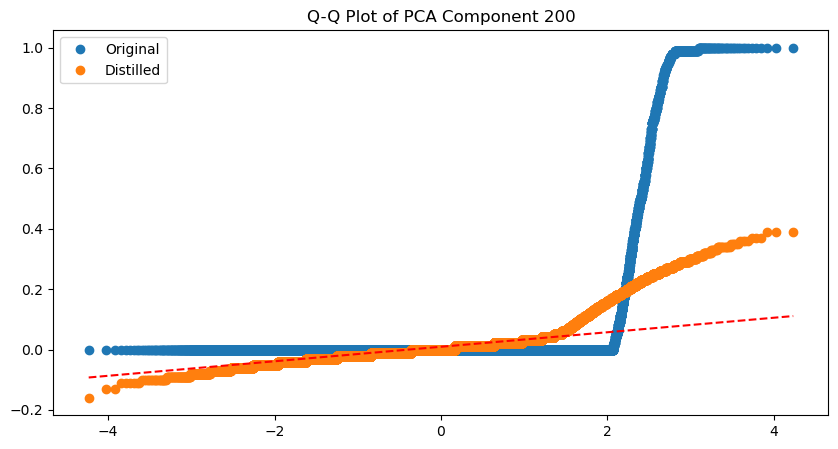

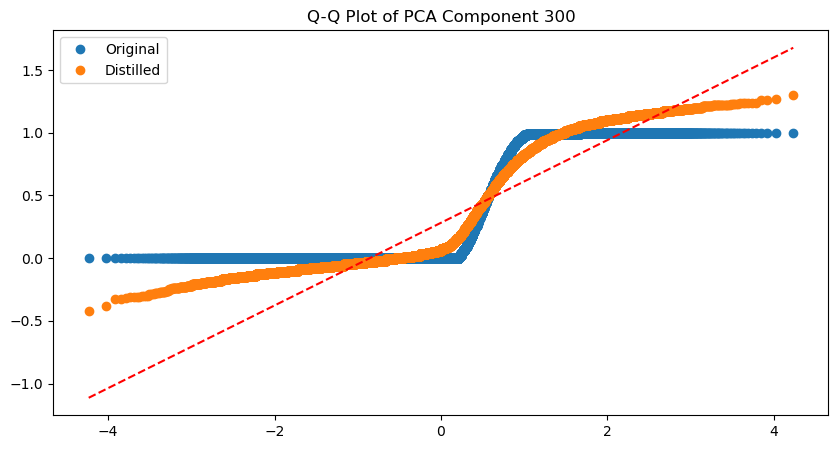

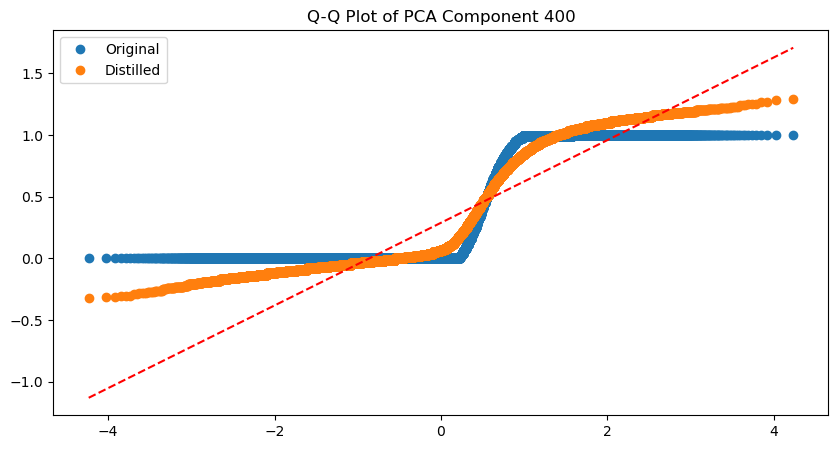

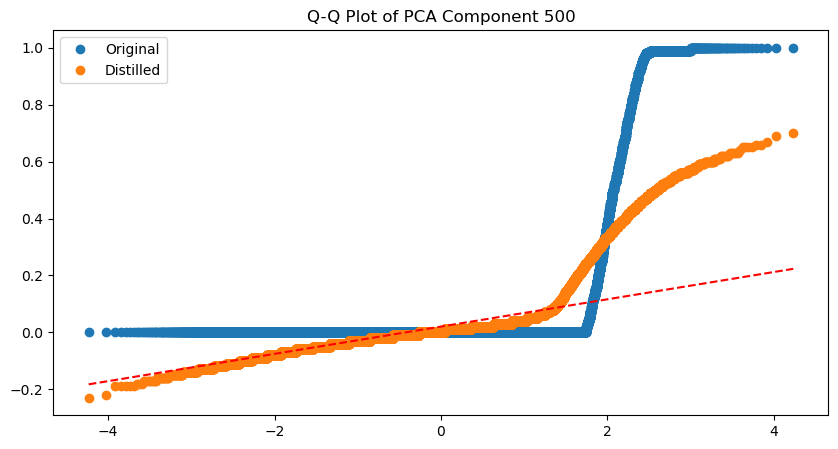

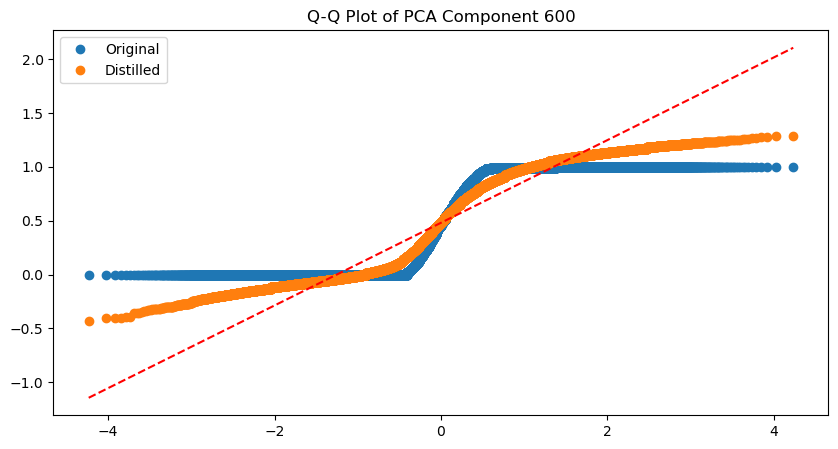

In [ ]:
import scipy.stats as stats

# Q-Q Plot with legends for overlaid plots
for i in [200,300,400,500,600]:  # Adjust the number of components to visualize
    plt.figure(figsize=(10, 5))
    
    # Plot for original data
    (osm_orig, osr_orig), (slope_orig, intercept_orig, r_orig) = stats.probplot(original_df[i], dist="norm")
    plt.plot(osm_orig, osr_orig, 'o', label='Original')
    
    # Plot for distilled data
    (osm_dist, osr_dist), (slope_dist, intercept_dist, r_dist) = stats.probplot(distilled_df[i], dist="norm")
    plt.plot(osm_dist, osr_dist, 'o', label='Distilled')
    
    plt.plot([min(osm_orig), max(osm_orig)], [min(osm_orig)*slope_orig+intercept_orig, max(osm_orig)*slope_orig+intercept_orig], 'r--')
    plt.title(f'Q-Q Plot of PCA Component {i}')
    plt.legend()
    plt.show()

t-SNE serves as a powerful tool for visually evaluating the effectiveness of data distillation techniques in preserving the intrinsic structure and relationships within high-dimensional datasets. Comparing t-SNE visualizations before and after dimensionality reduction provides insights into the quality of the distilled data and the extent of information preservation.

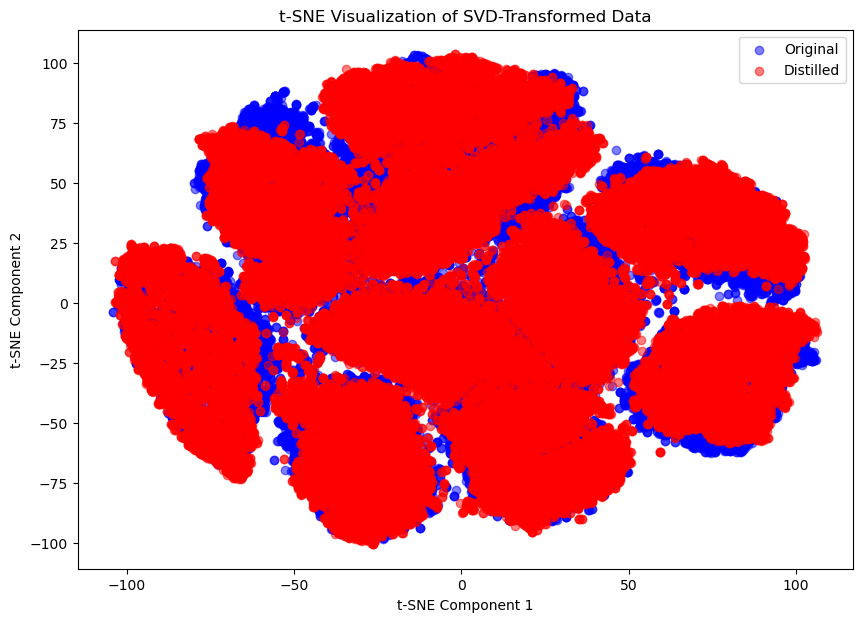

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
original_tsne = tsne.fit_transform(original_df)
distilled_tsne = tsne.fit_transform(distilled_df)

# Convert t-SNE results to DataFrame for easier handling
original_tsne_df = pd.DataFrame(original_tsne, columns=['TSNE1', 'TSNE2'])
distilled_tsne_df = pd.DataFrame(distilled_tsne, columns=['TSNE1', 'TSNE2'])

# Scatter plot of t-SNE results
plt.figure(figsize=(10, 7))
plt.scatter(original_tsne_df['TSNE1'], original_tsne_df['TSNE2'], alpha=0.5, label='Original', c='blue')
plt.scatter(distilled_tsne_df['TSNE1'], distilled_tsne_df['TSNE2'], alpha=0.5, label='Distilled', c='red')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('t-SNE Visualization of SVD-Transformed Data')
plt.legend()
plt.show()

The similarity between the distilled and original data suggests effective distribution matching 
during dimensionality reduction. Distribution matching ensures that the statistical properties 
and patterns present in the original data are preserved in the distilled data, indicating that 
the reduction process successfully retained crucial information while reducing dimensionality.




